In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings

warnings.simplefilter("ignore")
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [15]:
# load all datasets
TRAIN_SALES_CSV = 'sales_train.csv'
SHOPS_CSV = 'shops.csv'
ITEMS_CSV = 'items.csv'
ITEM_CATEGORY_CSV = 'item_categories.csv'

In [16]:

# Load datasets
df_train = pd.read_csv(TRAIN_SALES_CSV)
df_shop = pd.read_csv(SHOPS_CSV)
df_item = pd.read_csv(ITEMS_CSV)
df_itemcat = pd.read_csv(ITEM_CATEGORY_CSV)


In [17]:
df_itemcat.rename(columns={'item_category_name': 'item_category'}, inplace=True)
df_itemcat.rename(columns={'item_category_id': 'category_id'}, inplace = True)

In [18]:
# Merge train data with item and shop information
df = df_train.merge(df_item, on="item_id", how="left") \
             .merge(df_shop, on="shop_id", how="left") \
             .merge(df_itemcat, on="category_id", how="left")

# Drop unnecessary columns
df.drop(columns=["item_name"], inplace=True)

# Save merged data for future use
df.to_csv('merged_original.csv', index=False)

# Convert 'date' to datetime format and sort
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df.sort_values(by="date", ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Date Range: {df['date'].min()} to {df['date'].max()}")


Date Range: 2013-01-01 00:00:00 to 2015-10-31 00:00:00


# Exploratory Data Analysis (EDA)


a. Distribution of item_cnt_day



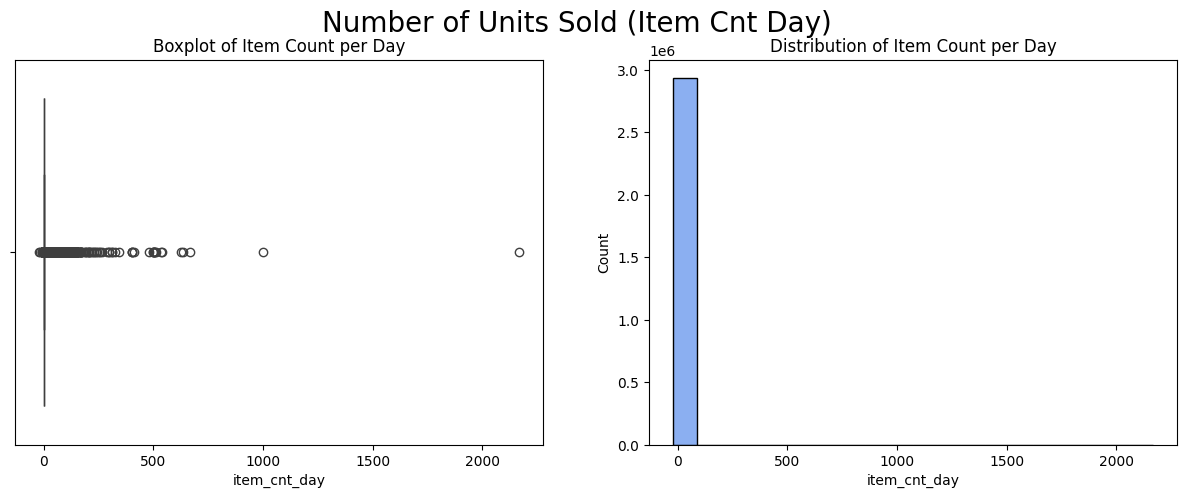

count   2935849.00
mean          1.24
std           2.62
min         -22.00
25%           1.00
50%           1.00
75%           1.00
max        2169.00
Name: item_cnt_day, dtype: float64


In [20]:
# Boxplot and Distribution plot for item_cnt_day
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x='item_cnt_day', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Item Count per Day')

sns.histplot(df['item_cnt_day'], bins=20, kde=False, ax=axes[1], color="cornflowerblue")
axes[1].set_title('Distribution of Item Count per Day')
plt.suptitle('Number of Units Sold (Item Cnt Day)', fontsize=20)
plt.show()

# Statistical Description
print(df['item_cnt_day'].describe())


In [21]:
print(f'Minimum value {df["item_cnt_day"].min()}')
print(f'Maximum value {df["item_cnt_day"].max()}')

Minimum value -22.0
Maximum value 2169.0


b. Handling Outliers in item_cnt_day


In [22]:
# Remove negative sales (returns) and cap at 95th percentile
print(f"Shape before outlier removal: {df.shape}")
df = df[df['item_cnt_day'] >= 0]
upper_quantile = df['item_cnt_day'].quantile(0.95)
df['item_cnt_day'] = np.where(df['item_cnt_day'] > upper_quantile, upper_quantile, df['item_cnt_day'])
print(f"Shape after outlier removal: {df.shape}")
print(f"Item Count Range: {df['item_cnt_day'].min()} to {df['item_cnt_day'].max()}")


Shape before outlier removal: (2935849, 9)
Shape after outlier removal: (2928493, 9)
Item Count Range: 1.0 to 2.0


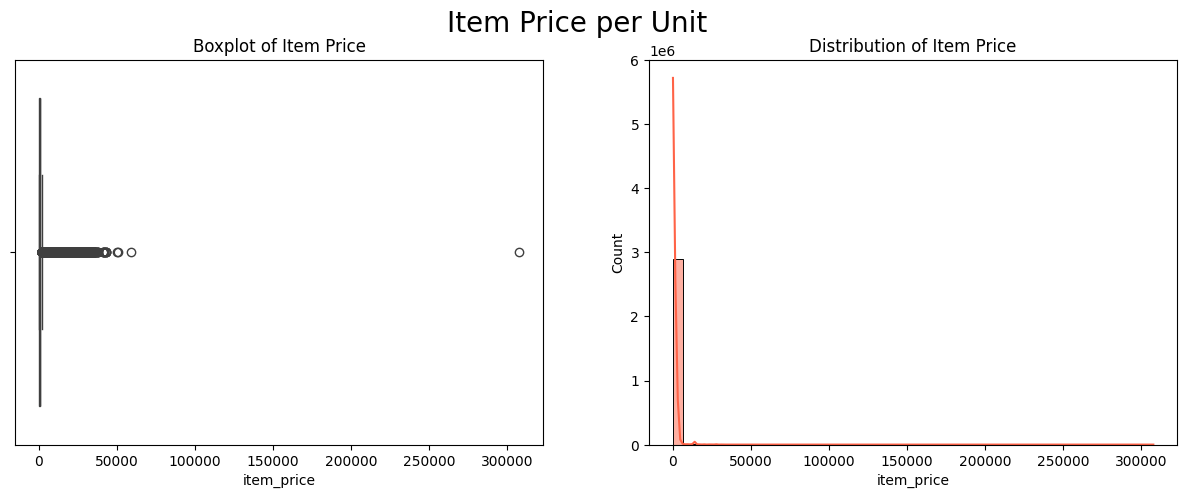

count   2928493.00
mean        889.47
std        1727.50
min          -1.00
25%         249.00
50%         399.00
75%         999.00
max      307980.00
Name: item_price, dtype: float64
Shape before price outlier removal: (2928493, 9)
Shape after price outlier removal: (2928492, 9)
Item Price Range: 0.07 to 2683.6409999995585


In [23]:
# Boxplot and Distribution plot for item_price
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.boxplot(x='item_price', data=df, ax=axes[0])
axes[0].set_title('Boxplot of Item Price')

sns.histplot(df['item_price'], bins=50, kde=True, ax=axes[1], color="tomato")
axes[1].set_title('Distribution of Item Price')
plt.suptitle('Item Price per Unit', fontsize=20)
plt.show()

# Statistical Description
print(df['item_price'].describe())

# Remove extreme outliers in item_price
print(f"Shape before price outlier removal: {df.shape}")
df = df[df['item_price'] >= 0]
upper_quantile = df['item_price'].quantile(0.95)
df['item_price'] = np.where(df['item_price'] > upper_quantile, upper_quantile, df['item_price'])
print(f"Shape after price outlier removal: {df.shape}")
print(f"Item Price Range: {df['item_price'].min()} to {df['item_price'].max()}")


In [24]:
df[df['item_price']<1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id,shop_name,item_category
531522,2013-06-01,5,6,11853,0.10,1.00,63,"Voronezh (Plekhanovskaya, 13)",Gifts - Soft toys
531531,2013-06-01,5,6,11857,0.10,1.00,63,"Voronezh (Plekhanovskaya, 13)",Gifts - Soft toys
531532,2013-06-01,5,6,11864,0.10,2.00,63,"Voronezh (Plekhanovskaya, 13)",Gifts - Soft toys
531533,2013-06-01,5,6,11868,0.10,1.00,63,"Voronezh (Plekhanovskaya, 13)",Gifts - Soft toys
531534,2013-06-01,5,6,11866,0.10,1.00,63,"Voronezh (Plekhanovskaya, 13)",Gifts - Soft toys
...,...,...,...,...,...,...,...,...,...
2882517,2015-10-01,33,44,15345,0.99,1.00,63,Samara Melody shopping center,Gifts - Soft toys
2885706,2015-10-02,33,58,15334,0.99,1.00,63,"Yakutsk TC"" Central """,Gifts - Soft toys
2890621,2015-10-04,33,22,15345,0.99,1.00,63,Moscow Shop C21,Gifts - Soft toys
2901930,2015-10-11,33,58,15334,0.99,1.00,63,"Yakutsk TC"" Central """,Gifts - Soft toys


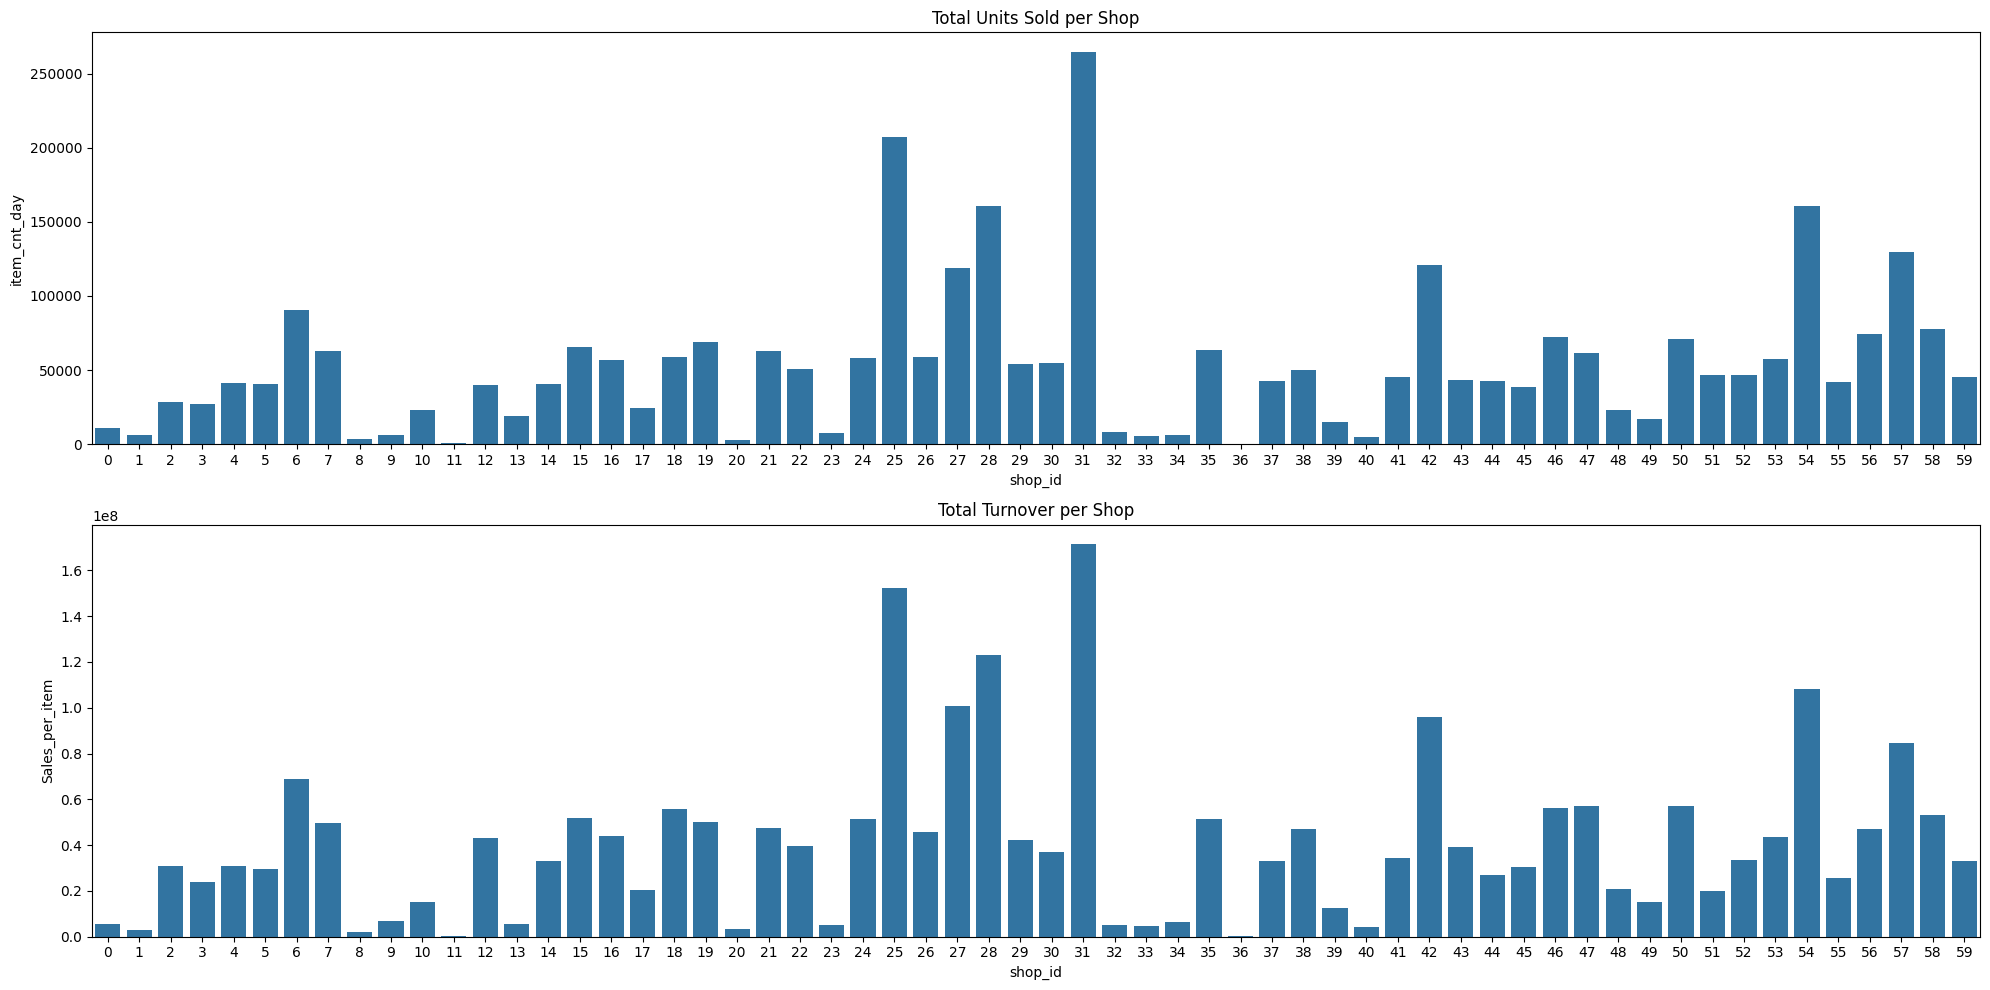

KeyboardInterrupt: 

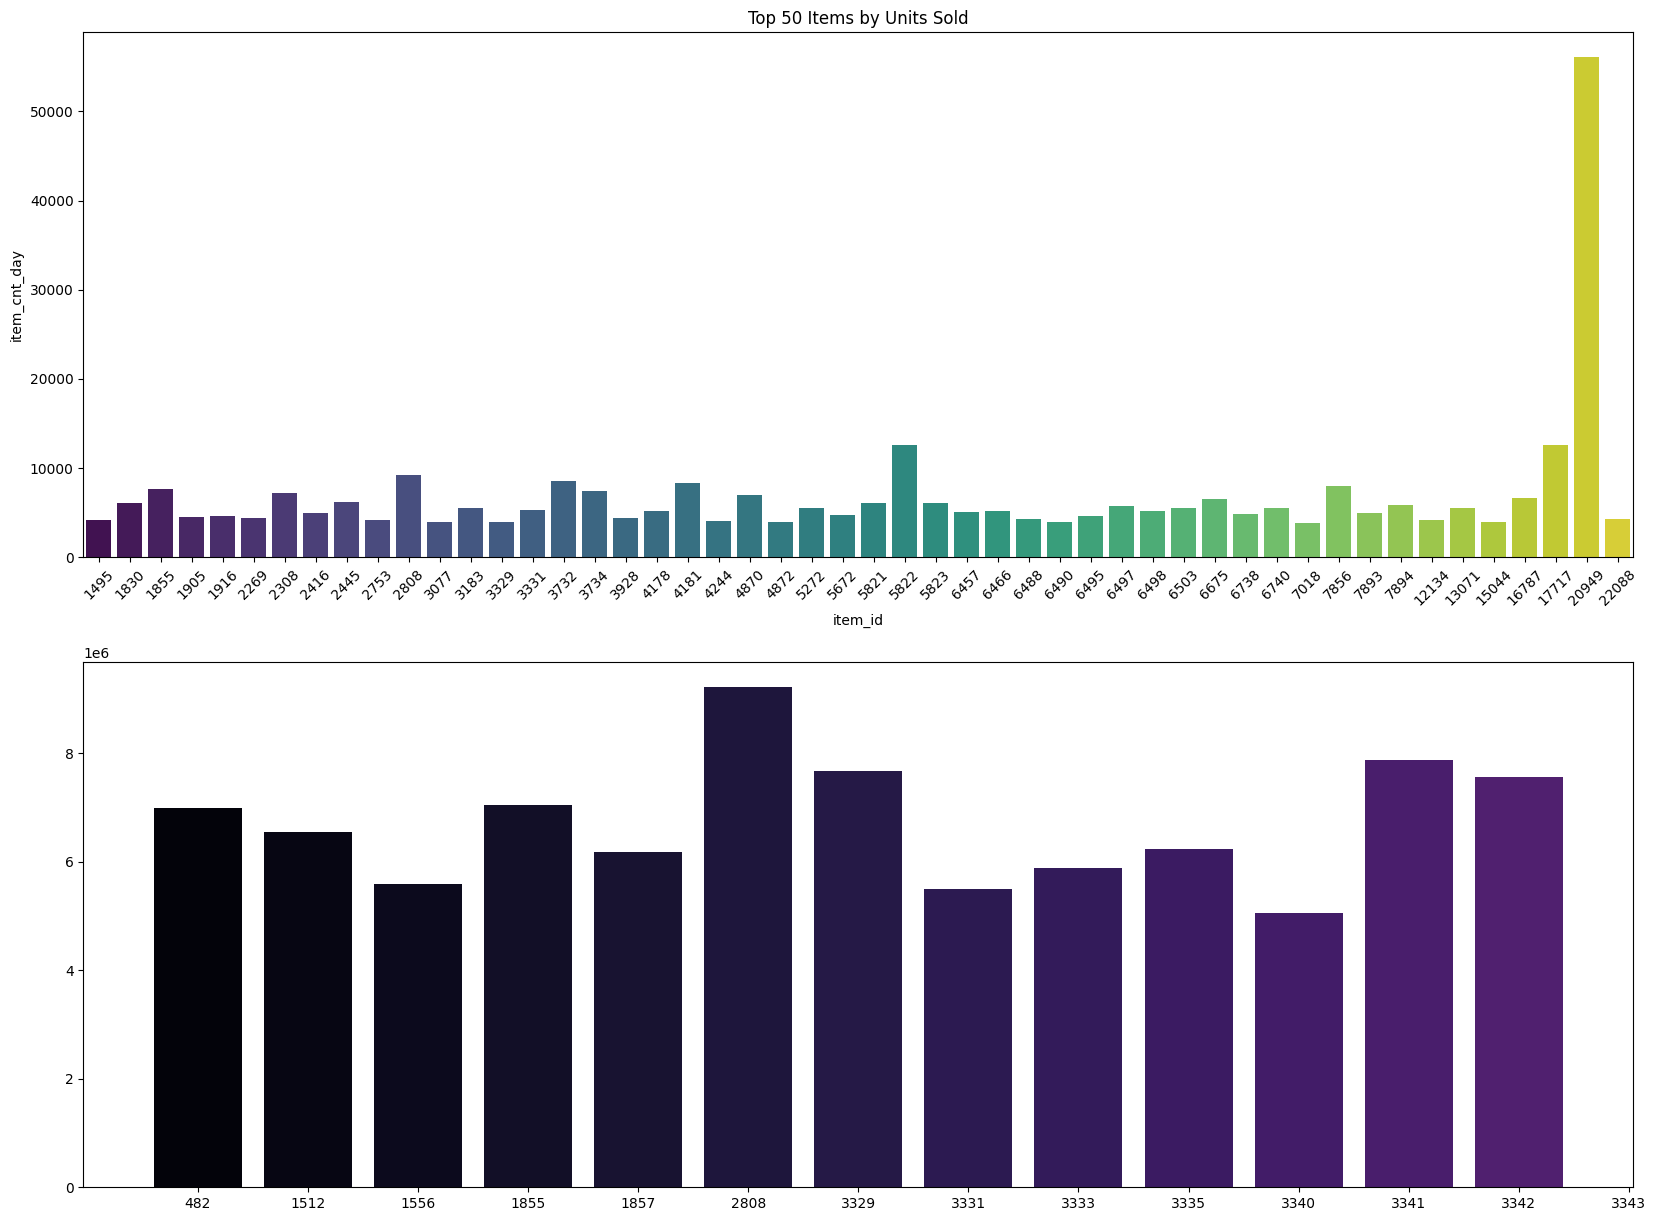

In [25]:
# Sales per shop
df['Sales_per_item'] = df['item_cnt_day'] * df['item_price']

df_tmp = df[['shop_id', 'Sales_per_item', 'item_cnt_day']]
df_tmp = pd.pivot_table(data=df_tmp, index=["shop_id"], aggfunc={"item_cnt_day": np.sum, "Sales_per_item": np.sum}).reset_index()

fig, axes = plt.subplots(2,1, figsize=(20,10))
sns.barplot(x='shop_id', y='item_cnt_day', data=df_tmp, ax=axes[0])
axes[0].set_title("Total Units Sold per Shop")

sns.barplot(x='shop_id', y='Sales_per_item', data=df_tmp, ax=axes[1])
axes[1].set_title("Total Turnover per Shop")

plt.tight_layout()
plt.show()

# Sales per item
df_tmp = df[['item_id', 'Sales_per_item', 'item_cnt_day']]
df_tmp = pd.pivot_table(data=df_tmp, index=["item_id"], aggfunc={"item_cnt_day": np.sum, "Sales_per_item": np.sum}).reset_index()

# Top 50 items by sales count and turnover
top_50_count = df_tmp.sort_values(by='item_cnt_day', ascending=False).head(50)
top_50_sales = df_tmp.sort_values(by='Sales_per_item', ascending=False).head(50)

fig, axes = plt.subplots(2,1, figsize=(20,15))
sns.barplot(x='item_id', y='item_cnt_day', data=top_50_count, ax=axes[0], palette='viridis')
axes[0].set_title("Top 50 Items by Units Sold")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x='item_id', y='Sales_per_item', data=top_50_sales, ax=axes[1], palette='magma')
axes[1].set_title("Top 50 Items by Turnover")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


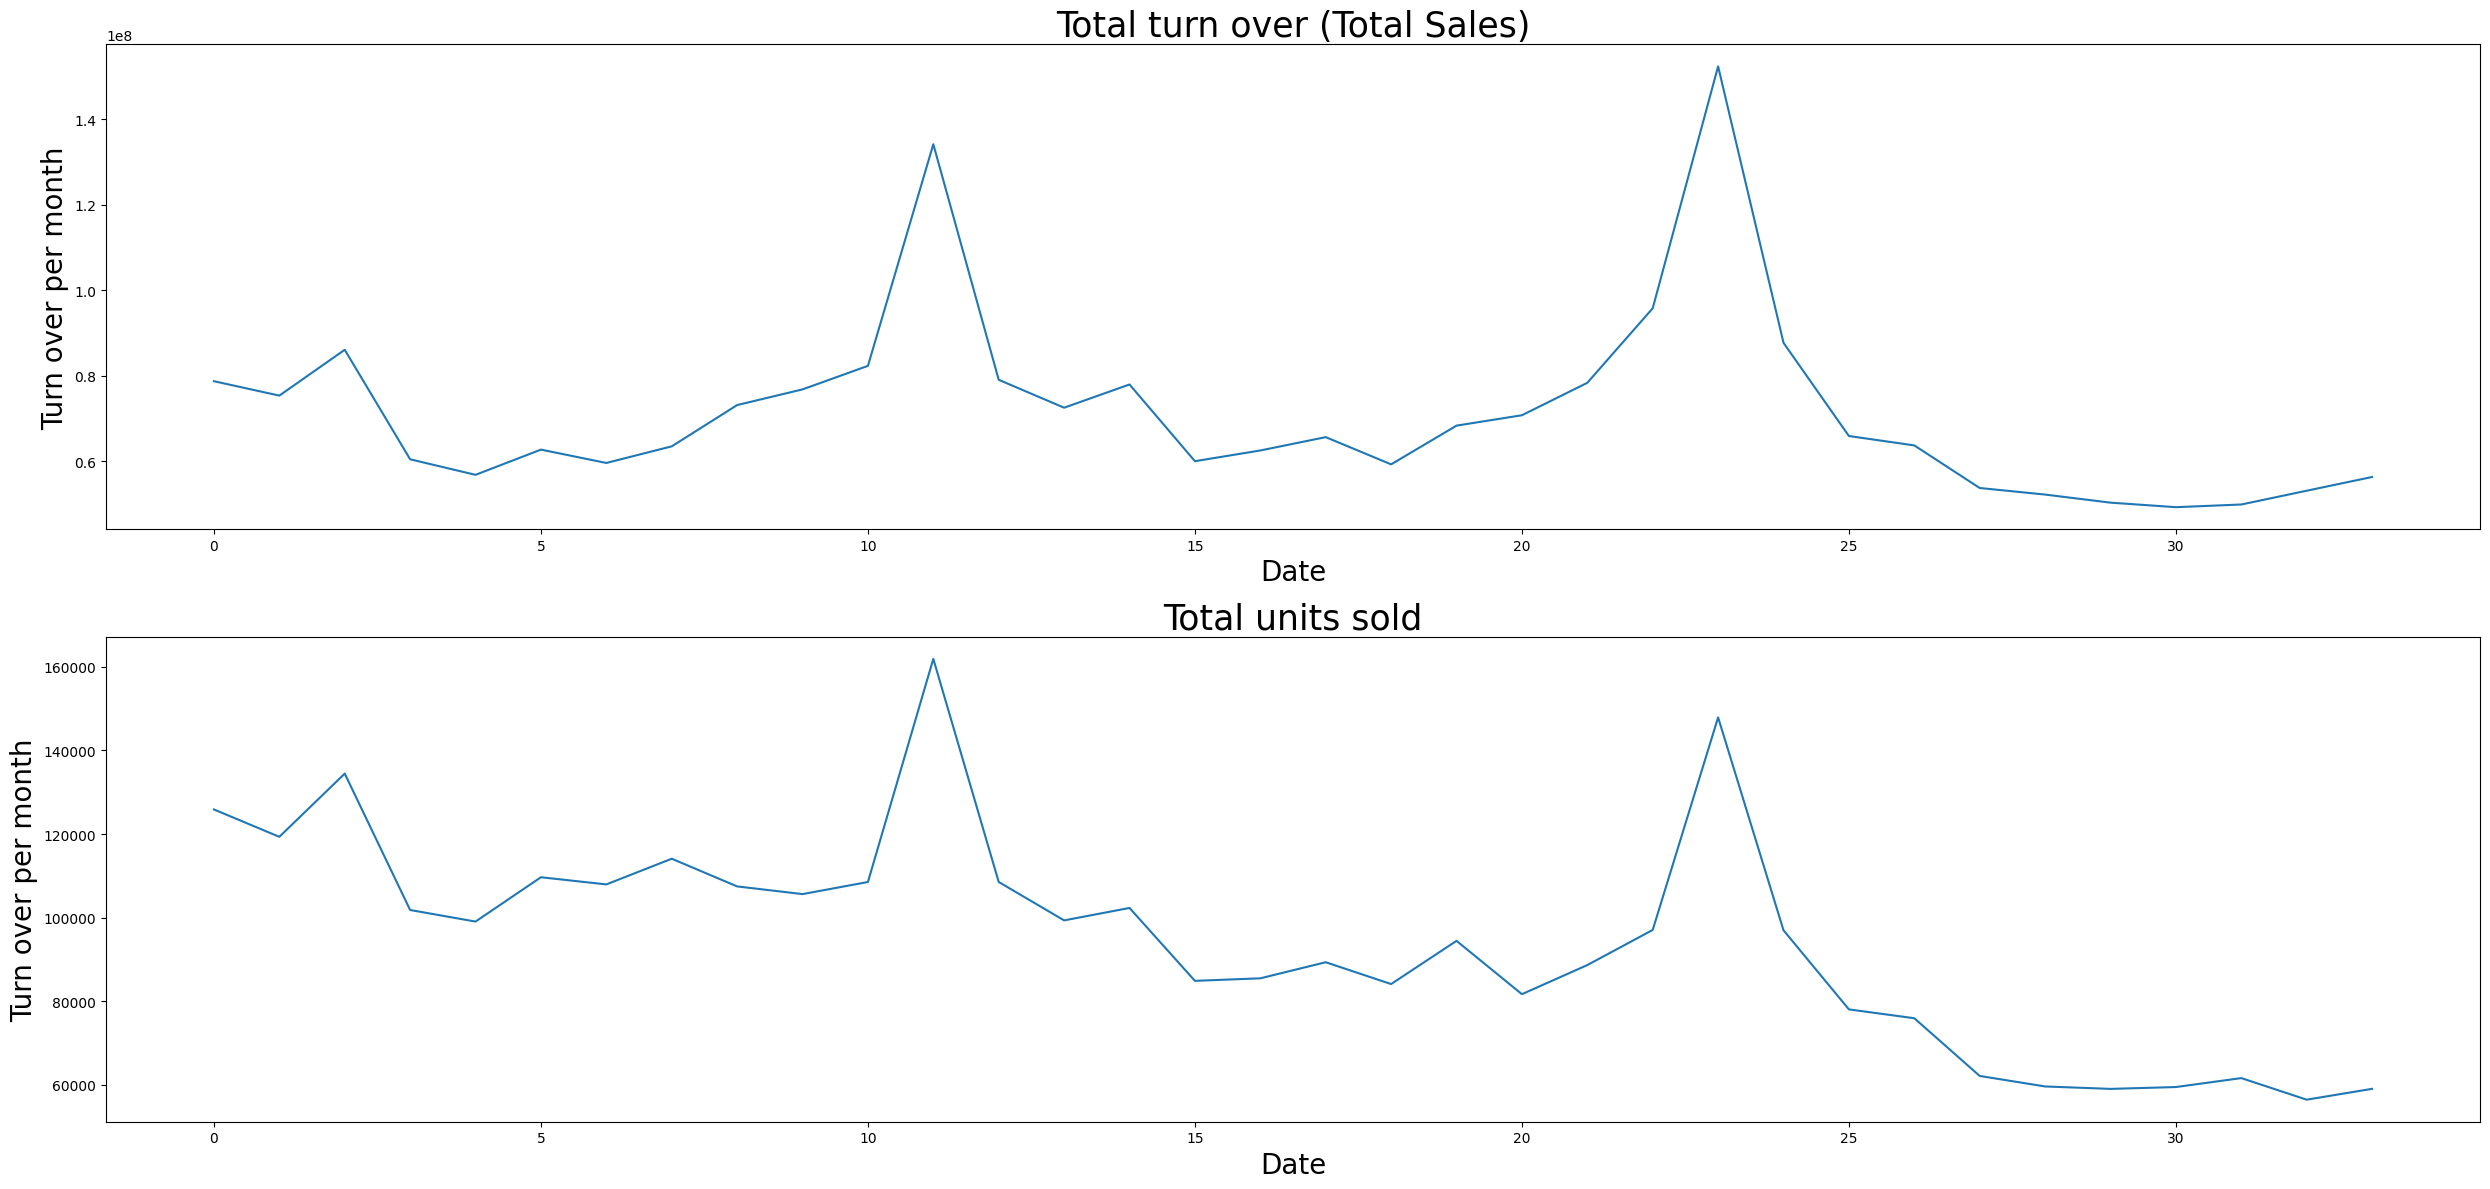

In [ ]:
df["Year"] = df["date"].dt.year
df["Month"] = df["date"].dt.month
df["day_of_month"] = df["date"].dt.day
df["day_of_week"] = df["date"].dt.day_of_week 

fig,axes = plt.subplots(2,1,figsize=(25,12))
df_tmp = df[['date_block_num','Month','Sales_per_item']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['Sales_per_item'],ax=axes[0])
axes[0].set_title('Total turn over (Total Sales)',fontsize="25")
axes[0].set_xlabel('Date',fontsize="20")
axes[0].set_ylabel('Turn over per month',fontsize="20")


df_tmp = df[['date_block_num','Month','item_cnt_day']].groupby(by=['date_block_num']).aggregate("sum").reset_index()
sns.lineplot(x=df_tmp['date_block_num'],y=df_tmp['item_cnt_day'],ax=axes[1])
axes[1].set_title('Total units sold',fontsize="25")
axes[1].set_xlabel('Date',fontsize="20")
axes[1].set_ylabel('Turn over per month',fontsize="20")

plt.tight_layout()
del df_tmp
plt.show()

In [ ]:
df

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,category_id,shop_name,item_category,Sales_per_item,Year,Month,day_of_month,day_of_week
0,2013-01-01,0,18,5823,2500.00,1.00,35,"Krasnoyarsk TC ""June""",Payment cards - PSN,2500.00,2013,1,1,1
1,2013-01-01,0,27,5573,849.00,1.00,2,"Moscow TC"" MEGA Belaya Dacha II """,Accessories - PS3,849.00,2013,1,1,1
2,2013-01-01,0,7,1006,399.00,1.00,67,"Voronezh SEC ""Maksimir""",Gifts - Development,399.00,2013,1,1,1
3,2013-01-01,0,19,17707,899.00,1.00,19,"Kursk TC "" Pushkinskiy """,Games - PS3,899.00,2013,1,1,1
4,2013-01-01,0,14,19548,149.00,1.00,40,"Kazan TC ""ParkHouse"" II",Cinema - DVD,149.00,2013,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-31,33,41,21386,169.00,1.00,40,RostovNaDon Mega shopping center,Cinema - DVD,169.00,2015,10,31,5
2935845,2015-10-31,33,21,988,199.00,1.00,37,"Moscow MTRC"" Afi Mall """,Cinema - Blu-Ray,199.00,2015,10,31,5
2935846,2015-10-31,33,41,21377,169.00,1.00,40,RostovNaDon Mega shopping center,Cinema - DVD,169.00,2015,10,31,5
2935847,2015-10-31,33,22,10207,1199.00,1.00,30,Moscow Shop C21,PC Games - Standard Editions,1199.00,2015,10,31,5


In [63]:
df_shop = pd.read_csv('shops_with_data.csv')

In [64]:
import re
def preprocess_shop_name(name):
    # Remove unnecessary quotes and specific terms
    name = re.sub(r'[!,"()]', '', name)  # Remove specific characters

    name = name.replace('"', '')  # Remove all double quotes
    name = name.replace("TC", "").replace("SEC", "").replace("TK", "")  # Remove specific terms
    name = name.strip()  # Remove leading and trailing whitespace
    # Capitalize each word for consistency
    name = ' '.join(word.capitalize() for word in name.split())
    return name

# Apply the preprocessing function to the shop_name column
df_shop['shop_name'] = df_shop['shop_name'].apply(preprocess_shop_name)

In [65]:
df_shop 

,shop_id,shop_name,city,region,shop_type,shop_size_sqft
0,0,Yakutsk Ordzhonikidze 56 Francs,Yakutsk,Yakutia,Franchise,1500
1,1,Yakutsk Central Fran,Yakutsk,Yakutia,Franchise,2000
2,2,Adygea Mega,Maykop,Adygea,Shopping Mall,3000
3,3,Balashikha Oktyabr-kinomir,Balashikha,Moscow Oblast,Shopping Mall,2500
4,4,Volga Volga Mall,Tolyatti,Samara,Shopping Mall,3500
5,5,Vologda Marmelad,Vologda,Vologda,Shopping Mall,2800
6,6,Voronezh Plekhanovskaya 13,Voronezh,Voronezh,Outlet,1200
7,7,Voronezh Maksimir,Voronezh,Voronezh,Shopping Mall,3200
8,8,Voronezh City-park Grad,Voronezh,Voronezh,Shopping Mall,4000
9,9,Outbound Trade,Moscow,Moscow,Outlet,1000


In [67]:
df_shop.to_csv('shops_with_data.csv', index=False)